In [1]:
#import

In [2]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import seaborn as sns
import tangram as tg

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/apon/anaconda3/envs/tangram-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#load data

In [4]:
adata_st = sq.datasets.visium_fluo_adata_crop()
adata_st = adata_st[
    adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()
img = sq.datasets.visium_fluo_image_crop()

adata_sc = sq.datasets.sc_mouse_cortex()

In [5]:
#get training genes according to some criteria

In [6]:
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
markers = list(np.unique(markers_df.melt().value.values))
len(markers)

1401

In [7]:
#premap data adjustment

In [8]:
tg.pp_adatas(adata_sc, adata_st, genes=markers)

INFO:root:1280 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14785 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [9]:
#run mapping

In [10]:
ad_map = tg.map_cells_to_space(adata_sc, adata_st,
    mode="cells",
#     mode="clusters",
#     cluster_label='cell_subclass',  # .obs field w cell types
    density_prior='rna_count_based',
    num_epochs=500,
#     device="cuda:0",
    device='cpu',
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1280 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.613, KL reg: 0.001
Score: 0.733, KL reg: 0.000
Score: 0.736, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000


INFO:root:Saving results..


# Info about the dataset

In [11]:
# visium data - not single cell resolution
# DEG for each cell type as training genes (~ 1400 total)

print("Shape of the mapping prob matrix:", ad_map.shape)

list(ad_map.obs.cell_subclass.unique()) #show cell subclass

Shape of the mapping prob matrix: (21697, 324)


['Pvalb',
 'L4',
 'Vip',
 'L2/3 IT',
 'Lamp5',
 'NP',
 'Sst',
 'L5 IT',
 'Oligo',
 'L6 CT',
 'L6 IT',
 'Sncg',
 'Serpinf1',
 'L5 PT',
 'Astro',
 'L6b',
 'Endo',
 'Peri',
 'Meis2',
 'Macrophage',
 'CR',
 'VLMC',
 'SMC']

# How many cells are mapped to a voxel with very high probability?

In [12]:
#NEW STUFF, PROB
#print(type(ad_map.X[1:]), ad_map.X[1:].shape)

#print(np.sum(ad_map.X, axis = 1))

#print(np.max(ad_map.X[1:], axis=0))

count_per_column = np.sum(ad_map.X > 0.9, axis=0)

count_per_column[:5]



array([26, 36, 31, 32, 40])

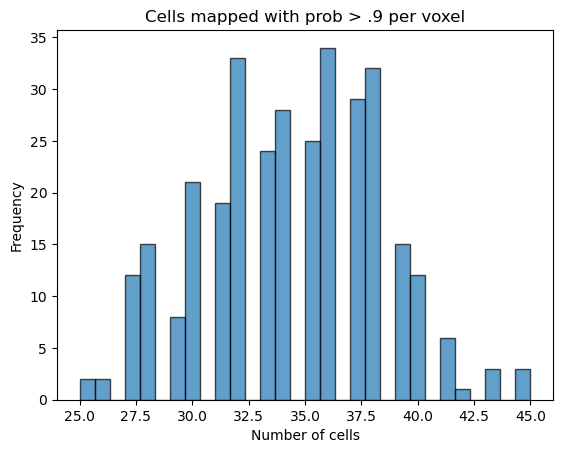

In [13]:
#PLOT HISTOGRAM
plt.hist(count_per_column, bins=30, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Number of cells')
plt.ylabel('Frequency')
plt.title('Cells mapped with prob > .9 per voxel')

# Show the plot
plt.show()


# do cells associated with high prob to the same voxel share a common cell type?

In [14]:
#

#SINGLLE VOXEL IMPLEMENTATION

indices = np.where(ad_map.X[:, 0] > 0.9)[0]

# Store unique cell subclass types
cell_subclass_types = set(ad_map.obs.cell_subclass.iloc[indices])

# Print unique cell types
print(cell_subclass_types)

{'Sst', 'L5 IT', 'Sncg', 'Lamp5', 'Vip', 'Pvalb', 'L6 IT', 'L6 CT', 'NP', 'L5 PT'}


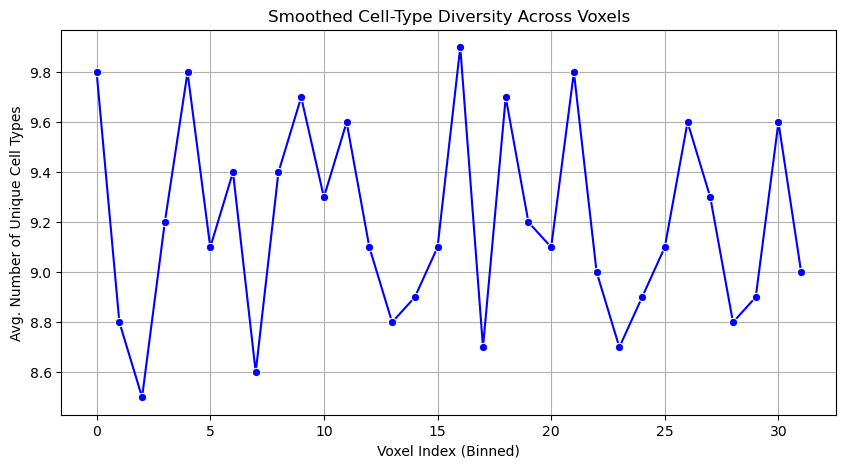

In [15]:
#ALL VOXEL IMPLEMENTATION
# Ensure `ad_map.X` is a dense NumPy array
matrix = ad_map.X
if not isinstance(matrix, np.ndarray):
    matrix = matrix.toarray()  

num_voxels = matrix.shape[1]  # Total voxels
unique_cell_counts = []

# Iterate over all voxels (columns in `ad_map.X`)
for voxel in range(num_voxels):
    indices = np.where(matrix[:, voxel] > 0.9)[0]
    unique_cell_types = set(ad_map.obs.cell_subclass.iloc[indices])
    unique_cell_counts.append(len(unique_cell_types))

bin_size = 10  # Group voxels into bins of 10

# Ensure the length is a multiple of bin_size
valid_length = (len(unique_cell_counts) // bin_size) * bin_size
trimmed_counts = unique_cell_counts[:valid_length]  # Trim extra voxels

# Reshape and average within bins
binned_voxels = np.array(trimmed_counts).reshape(-1, bin_size).mean(axis=1)

# Plot smoothed line plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(binned_voxels)), y=binned_voxels, marker="o", linestyle="-", color="b")
plt.xlabel("Voxel Index (Binned)")
plt.ylabel("Avg. Number of Unique Cell Types")
plt.title("Smoothed Cell-Type Diversity Across Voxels")
plt.grid(True)
plt.show()


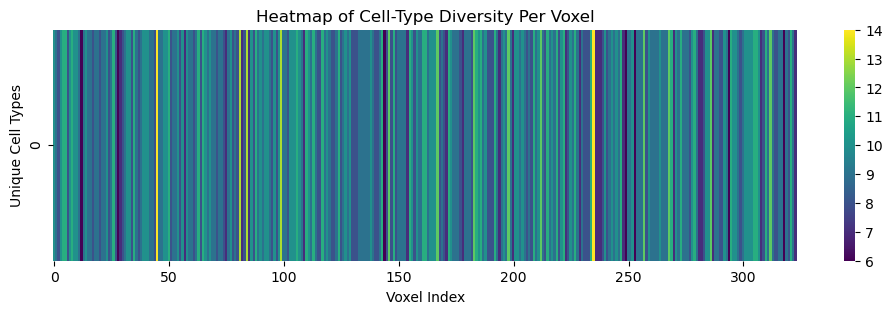

In [16]:
#ALL VOXEL IMPLEMENTATION - HEATMAP
plt.figure(figsize=(12, 3))
sns.heatmap(np.array(unique_cell_counts).reshape(1, -1), cmap="viridis", cbar=True, xticklabels=50)
plt.xlabel("Voxel Index")
plt.ylabel("Unique Cell Types")
plt.title("Heatmap of Cell-Type Diversity Per Voxel")
plt.show()

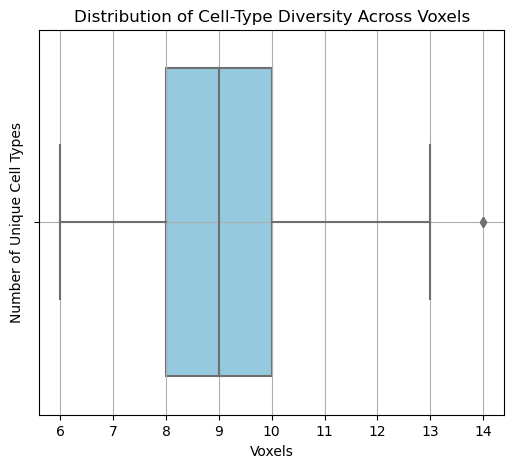

In [17]:
#BOX PLOT
plt.figure(figsize=(6, 5))
sns.boxplot(unique_cell_counts, color="skyblue")
plt.xlabel("Voxels")
plt.ylabel("Number of Unique Cell Types")
plt.title("Distribution of Cell-Type Diversity Across Voxels")
plt.grid(True)
plt.show()

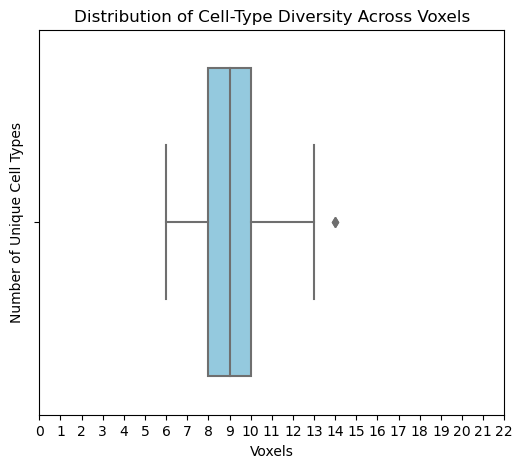

In [18]:
#2ND BOXPLOT
plt.figure(figsize=(6, 5))
sns.boxplot(unique_cell_counts, color="skyblue")
plt.xticks([i for i in range(len(list(ad_map.obs.cell_subclass.unique())))])
plt.xlabel("Voxels")
plt.ylabel("Number of Unique Cell Types")
plt.title("Distribution of Cell-Type Diversity Across Voxels")
plt.grid(False)
plt.show()

# Cell type distributions per voxel

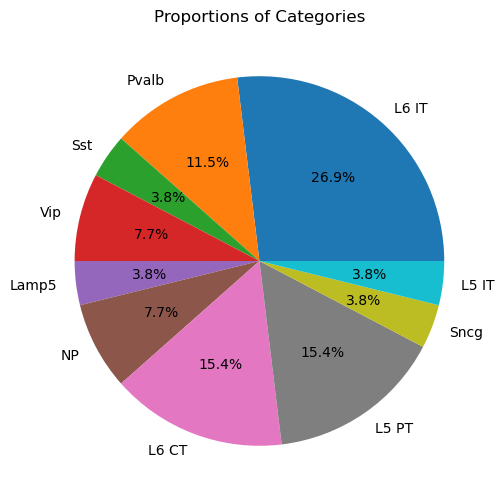

In [19]:
#SINGLE VOXEL IMPLEMENTATION
from collections import Counter

indices = np.where(ad_map.X[:, 0] > 0.9)[0] #indices of cells mapped to the voxel with high probability

cell_subclass_counts = Counter(list(ad_map.obs.cell_subclass.iloc[indices])) #count celltypes

total = sum(cell_subclass_counts.values()) # total cells

proportions = {key: value / total for key, value in cell_subclass_counts.items()} # calculate proportions

plt.figure(figsize=(6, 6))
plt.pie(proportions.values(), labels=proportions.keys(), autopct="%1.1f%%")
plt.title("Proportions of Categories")
plt.show()


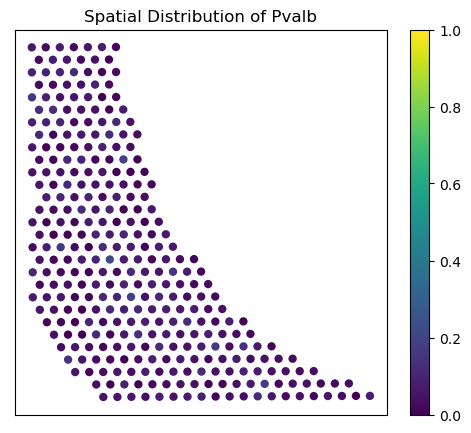

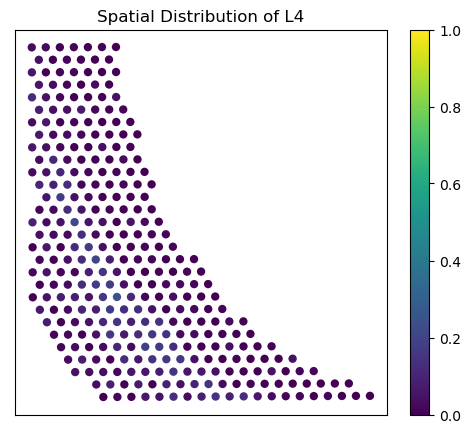

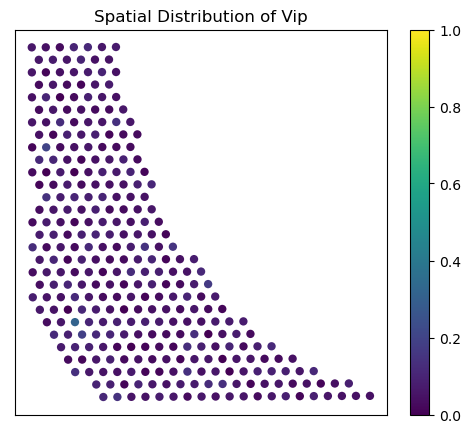

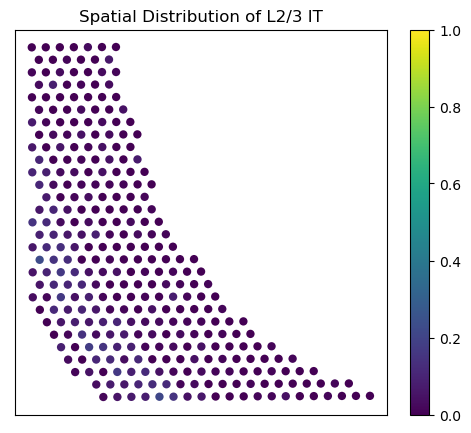

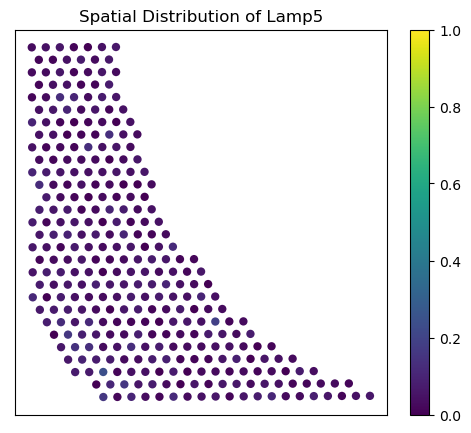

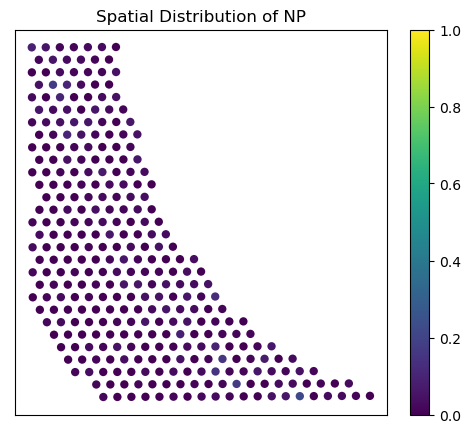

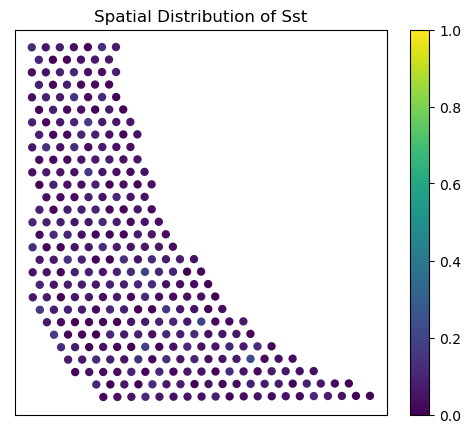

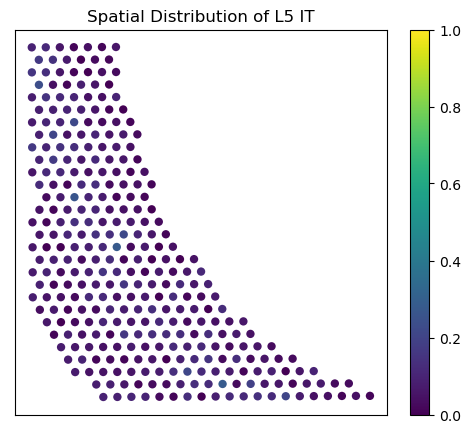

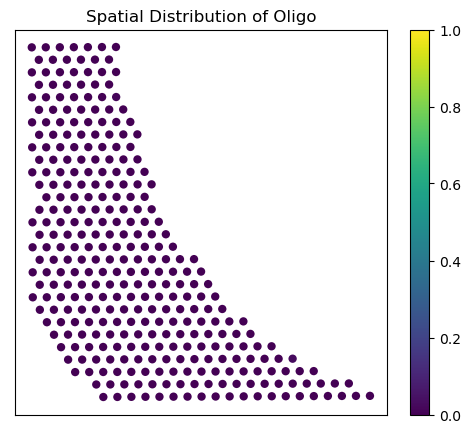

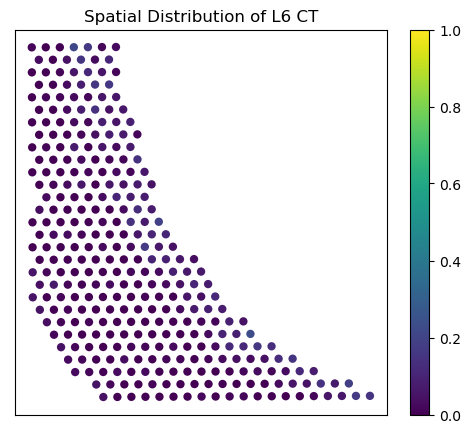

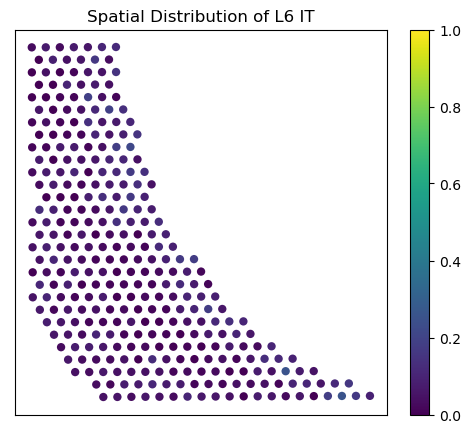

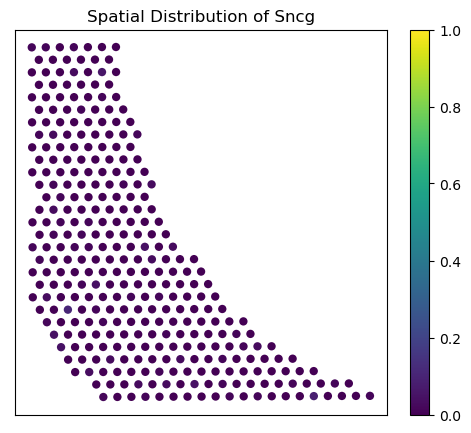

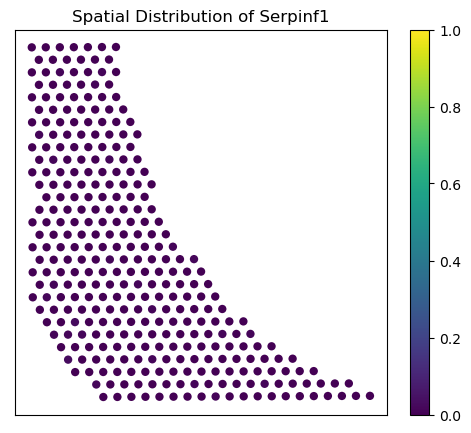

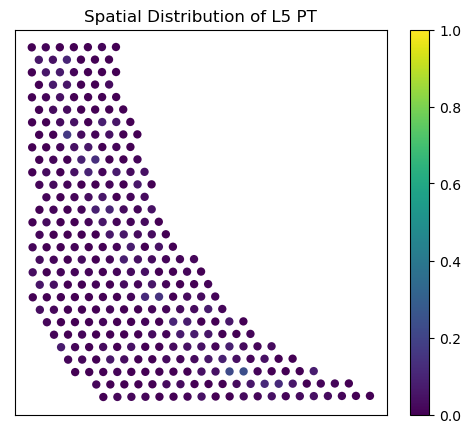

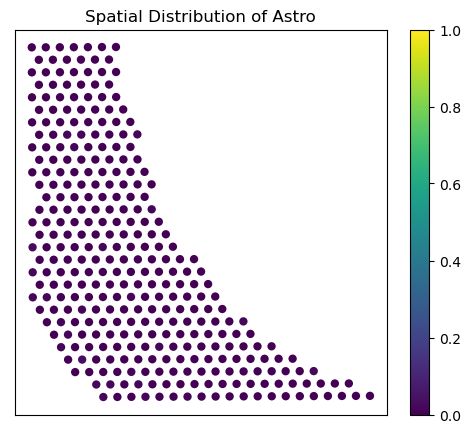

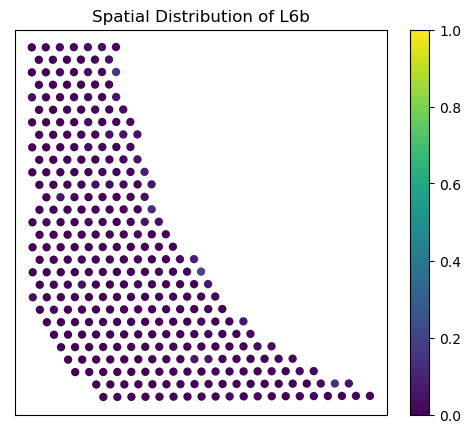

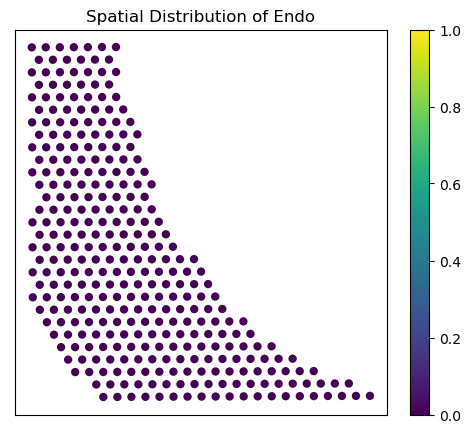

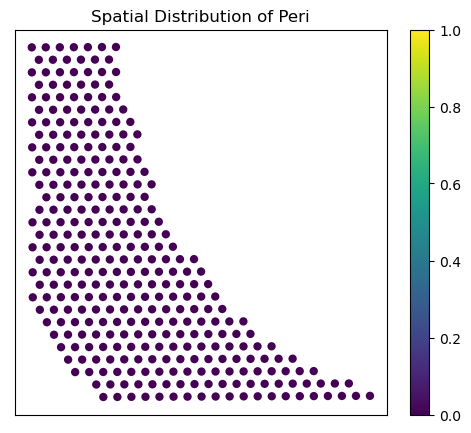

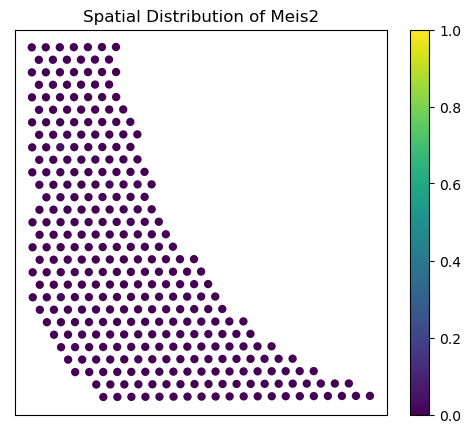

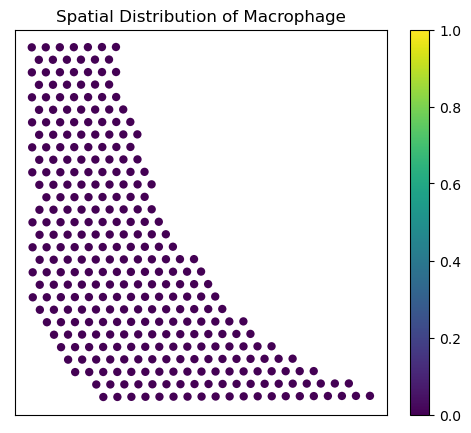

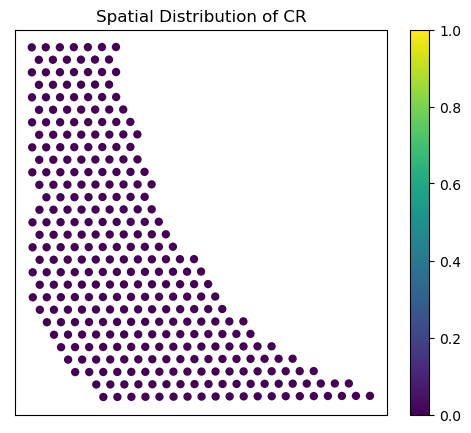

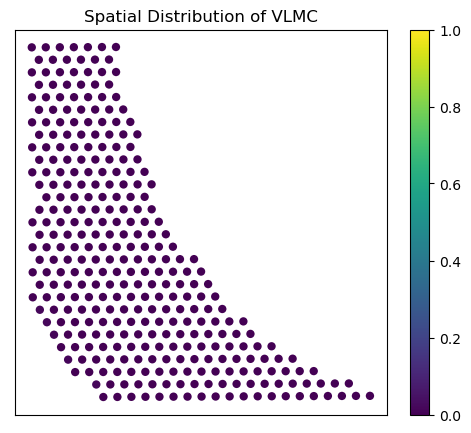

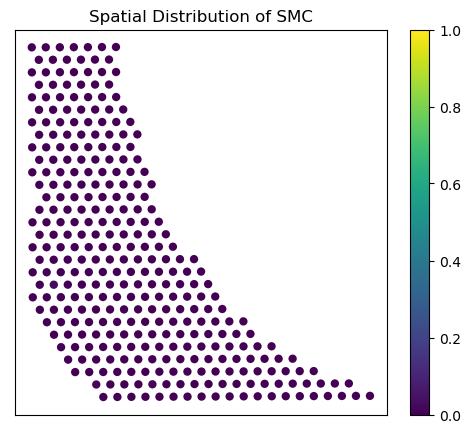

In [21]:
cell_types = ad_map.obs.cell_subclass.unique() #get cell types

voxel_coords = adata_st.obsm["spatial"]  #spatial coordinates for voxels

vmin, vmax = 0, 1  # Ensures all plots use the same scale


for cell_type in cell_types:
    
    cell_indices = np.where(ad_map.obs.cell_subclass == cell_type)[0] # get all cells of the same celltype

    high_prob_mask = ad_map.X[cell_indices, :] > 0.9 # get cells mapped with more than 90% prob

    # Compute sum of probabilities for this cell type across all voxels
    celltype_probs = ad_map.X[cell_indices, :] * high_prob_mask
    celltype_probs = celltype_probs.sum(axis=0)  # Sum over cells to get per-voxel values

    # Normalize to get proportions
    voxel_sums = ad_map.X.sum(axis=0)  # Sum over cells to get per-voxel values
    proportions = np.divide(celltype_probs, voxel_sums, where=voxel_sums > 0)

    # Plot scatter plot with color gradient
    plt.figure(figsize=(6, 5))
    plt.scatter(voxel_coords[:, 0], voxel_coords[:, 1], c=proportions, cmap="viridis", vmin=vmin, vmax=vmax, edgecolors="none")
    plt.colorbar()

    # Remove axis labels and ticks
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Spatial Distribution of {cell_type}")

    plt.show()


